# Timeshift

In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon

### Simulation parameters

In [2]:
# Simulation parameters
N = 2
L = N*2   # half-filling
t = 0
U = 0.5
mu = -0.1
    
# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta)      # worm end fugacity

### Create a worldline configuration 

In [3]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

### Insert a worm or antiworm

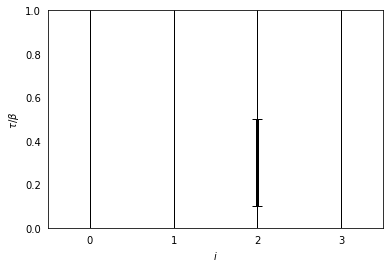

In [4]:
# Insert a worm or antiworm
i = 2
n_i = alpha[i]
tau_t = 0.1
tau_h = 0.5
if tau_t < tau_h:
    data_struct[i].append([tau_t,n_i+1,(i,i)])
    data_struct[i].append([tau_h,n_i,(i,i)])
    tail_loc = [i,1]
    head_loc = [i,2]
else: # antiworm
    data_struct[i].append([tau_h,n_i-1,(i,i)])
    data_struct[i].append([tau_t,n_i,(i,i)]) 
    head_loc = [i,1]
    head_loc = [i,2]

pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many timeshifts

In [5]:
# Do timeshift many times on the above configuration
mc_steps = int(1E+05)
worm_lengths = np.zeros(mc_steps)  # create array to save worm lengths
accepted = 0
rejected = 0
for m in range(mc_steps):
    tau_1 = data_struct[head_loc[0]][head_loc[1]][0]
    tau_2 = data_struct[tail_loc[0]][tail_loc[1]][0]
    worm_length = abs(tau_1-tau_2)
    worm_lengths[m] = worm_length
        
    pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu)
    
    # Count accepted updates  
    if tau_1 != data_struct[head_loc[0]][head_loc[1]][0] or (
       tau_2 != data_struct[tail_loc[0]][tail_loc[1]][0] ):
        accepted += 1

    # Count rejected updates  
    if tau_1 == data_struct[head_loc[0]][head_loc[1]][0] and (
       tau_2 == data_struct[tail_loc[0]][tail_loc[1]][0] ):
        rejected += 1

# Print the number of accepted time shifts
print("Accepted: %.4f %%"%(accepted/mc_steps*100))
print("Rejected: %.4f %%"%(rejected/mc_steps*100))

Accepted: 100.0000 %
Rejected: 0.0000 %


### Histogram of wormlengths

n_loc: [1.19413089e+02 3.91418621e+01 2.30856172e+01 1.62041653e+01
 1.23810836e+01 9.94819376e+00 8.26387643e+00 7.02870572e+00
 6.08416076e+00 5.33846574e+00 4.73480681e+00 4.23613133e+00
 3.81724343e+00 3.46041264e+00 3.15279963e+00 2.88487842e+00
 2.64943235e+00 2.44089429e+00 2.25490079e+00 2.08798346e+00
 1.93735070e+00 1.80073023e+00 1.67625376e+00 1.56237100e+00
 1.45778476e+00 1.36140134e+00 1.27229211e+00 1.18966354e+00
 1.11283345e+00 1.04121217e+00 9.74287352e-01 9.11611718e-01
 8.52793037e-01 7.97485910e-01 7.45384987e-01 6.96219321e-01
 6.49747658e-01 6.05754478e-01 5.64046654e-01 5.24450614e-01
 4.86809930e-01 4.50983252e-01 4.16842532e-01 3.84271498e-01
 3.53164328e-01 3.23424503e-01 2.94963809e-01 2.67701458e-01
 2.41563325e-01 2.16481277e-01 1.92392576e-01 1.69239357e-01
 1.46968165e-01 1.25529538e-01 1.04877650e-01 8.49699723e-02
 6.57669904e-02 4.72319374e-02 2.93305606e-02 1.20309100e-02]
n_prime_area:  2.017216110992598
pdf_area:  60.057871705134275


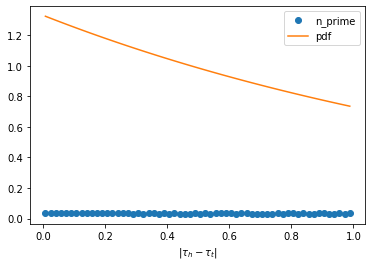

In [6]:
# Get the largest and smallest worm length
min_length = np.min(worm_lengths)
max_length = np.max(worm_lengths)

# Generating the bin edges
#bins = np.histogram_bin_edges(worm_lengths,bins=50)

# Histogram of wormlengths
loc = 0
b = 1
scale = 1/abs(U-mu)

x = np.linspace(-0.6+loc,loc+b+0.6,1000)

n, bins = np.histogram(worm_lengths, bins=60, density=1)
dtau = 0.5*(bins[:-1]+bins[1:])
pdf = truncexpon.pdf(dtau,b=b/scale,loc=loc,scale=scale)
n_loc = (1-dtau)/dtau
n_prime = n/n_loc
n_prime /= (np.sum(n_prime)*dtau)

print("n_loc:", n_loc)

#pdf_area = quad(n_prime,0,1)
#print("pdf area: ", pdf)
print("n_prime_area: ", np.sum(n_prime))
print("pdf_area: ", np.sum(pdf))

fig, ax = plt.subplots(1, 1)
ax.plot(dtau,n_prime,"o",label="n_prime")
ax.plot(dtau,pdf,label='pdf')
#ax.plot(dtau,n_loc,label='n_loc')
#ax.plot(dtau,n_loc/pdf/n,label='n_loc/pdf/n')
#ax.hist(worm_lengths,bins=bins,density=True,histtype='stepfilled',alpha=0.2) 
ax.set_xlabel(r"$\vert \tau_h - \tau_t \vert $") ;
#ax.set_yscale("log");
plt.legend()
#plt.savefig("%d_%d_%.4f_%.4f_%.4f_%d.pdf"%(L,N,U,mu,t,mc_steps))